### Importing libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Loading the dataset

In [2]:
simulated_cleaned_tx_df = pd.read_csv('../SavedData/dataset2_cleaned.csv')

In [3]:
simulated_cleaned_tx_df

,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name,Datetime
0,01/01/2023,00:00:00,678330503.0,2971.000000,1584.00,NaN,Westport Care Home,2023-01-01 00:00:00
1,01/01/2023,00:00:00,472213568.0,3792.000000,1950.00,NaN,Barbiee Boutique,2023-01-01 00:00:00
2,01/01/2023,00:00:00,472213568.0,3012.000000,-780.00,283027736.0,NaN,2023-01-01 00:00:00
3,01/01/2023,00:00:00,283027736.0,1787.000000,780.00,472213568.0,NaN,2023-01-01 00:00:00
4,01/01/2023,00:00:00,624500124.0,3226.000000,1825.00,NaN,Fat Face,2023-01-01 00:00:00
...,...,...,...,...,...,...,...,...
229189,06/12/2023,20:54:00,581655972.0,45935.206861,-41.06,NaN,Tesco,2023-12-06 20:54:00
229190,06/12/2023,20:55:00,786141370.0,-244.837500,-62.35,NaN,Sainsbury Local,2023-12-06 20:55:00
229191,06/12/2023,21:05:00,824916823.0,9709.172159,-32.94,NaN,Deliveroo,2023-12-06 21:05:00
229192,06/12/2023,21:13:00,366550080.0,26834.165794,-19.25,NaN,Amazon,2023-12-06 21:13:00


### Splitting the data into training and testing 

In [4]:
copied_simulated_tx_df = simulated_cleaned_tx_df.copy()

# Splitting the copied dataset into historical_transactions and testing_transactions 
training_transactions, testing_transactions = train_test_split(copied_simulated_tx_df, test_size=0.2, random_state=12)

# Displaying the shapes to verify the split
training_transactions.shape, testing_transactions.shape


((183355, 8), (45839, 8))

In [5]:
testing_transactions.to_csv('../SavedData/dataset2_testing_transaction.csv', index=False)

In [6]:
training_transactions.to_csv('../SavedData/dataset2_training_transaction.csv',index=False)

### Splitting the training transactions into payments and expenditures

In [7]:
payments_training_df = training_transactions[training_transactions['Amount'] > 0]
expenditures_training_df = training_transactions[training_transactions['Amount'] < 0]

In [8]:
# Taking the absolute values of the amount column
expenditures_training_df["Amount"] = expenditures_training_df["Amount"].abs()

expenditures_training_df

/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_8631/721076894.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  expenditures_training_df["Amount"] = expenditures_training_df["Amount"].abs()


,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name,Datetime
109964,25/06/2023,11:05:00,975345315.0,20105.404800,80.50,NaN,Topshop,2023-06-25 11:05:00
190427,17/10/2023,12:57:00,162370388.0,-2312.382900,43.42,NaN,Tesco,2023-10-17 12:57:00
81046,02/05/2023,19:18:00,145553416.0,-1516.558550,29.11,NaN,Tesco,2023-05-02 19:18:00
89182,22/05/2023,05:18:00,145387690.0,3671.032538,2.37,NaN,Sainsbury Local,2023-05-22 05:18:00
61119,31/03/2023,23:59:00,310171581.0,-651.334154,18.99,NaN,PureGym,2023-03-31 23:59:00
...,...,...,...,...,...,...,...,...
206083,05/11/2023,07:55:00,550169791.0,22875.430900,45.04,NaN,Etsy,2023-11-05 07:55:00
36482,23/02/2023,12:38:00,554792076.0,2248.810443,75.74,NaN,Topshop,2023-02-23 12:38:00
40177,01/03/2023,00:00:00,624563756.0,-14.727071,822.00,NaN,LBG,2023-03-01 00:00:00
150781,24/08/2023,20:15:00,176922958.0,1440.312330,37.43,NaN,Deliveroo,2023-08-24 20:15:00


## Creating an anomaly detection model using IQR for thresholds

### Threshold function

In [9]:
def calculate_thresholds(group, multiplier, percent_increment):
    quantiles = group['Amount'].quantile([0.25, 0.5, 0.75])
    IQR = quantiles[0.75] - quantiles[0.25]
    
    if IQR == 0:
        # When there's no variability, use the median and apply percent increment
        threshold = quantiles[0.5] * (1 + percent_increment)
    else:
        # Standard threshold calculation using IQR
        threshold = quantiles[0.75] + multiplier * IQR
    
    return threshold


### Creating anomaly detection dataframe: expenditures

In [10]:
# Ensure anomaly_detection_by_expenditures_df is indexed by 'Account No'
anomaly_detection_by_expenditures_df = expenditures_training_df[['Account No']].drop_duplicates().reset_index(drop=True)
anomaly_detection_by_expenditures_df.set_index('Account No', inplace=True)

# Assuming multipliers and percent_increments are defined as before
multipliers = [1.5, 3, 5]
percent_increments = [0.333, 0.666, 1]

# Define threshold columns
threshold_columns = ['Overall_Threshold_1_IQR', 'Overall_Threshold_2_IQR', 'Overall_Threshold_3_IQR']

# Initialising columns in anomaly_detection_by_expenditures_df to store threshold values
for col in threshold_columns:
    anomaly_detection_by_expenditures_df[col] = np.nan

# Calculate thresholds and update anomaly_detection_by_expenditures_df
for multiplier, percent_increment, col_name in zip(multipliers, percent_increments, threshold_columns):
    # Calculate thresholds for each Account No group
    thresholds = expenditures_training_df.groupby('Account No').apply(
        lambda group: calculate_thresholds(group, multiplier, percent_increment)
    ).reset_index(name=col_name)
    
    # Correctly index the thresholds DataFrame to facilitate direct mapping
    thresholds.set_index('Account No', inplace=True)
    
    # Map calculated thresholds to anomaly_detection_by_expenditures_df
    anomaly_detection_by_expenditures_df[col_name] = anomaly_detection_by_expenditures_df.index.map(
        thresholds[col_name]
    )

In [11]:
# For Threshold 1 (1.5 * IQR)
thresholds_1 = expenditures_training_df.dropna(subset=['Account No', 'Third Party Account No']).groupby(['Account No', 'Third Party Account No']).apply(lambda group: calculate_thresholds(group, 1.5, 0.333)).reset_index(name='Threshold_1')
thresholds_structured_1 = thresholds_1.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Account No'], x['Threshold_1']))).to_dict()

# For Threshold 2 (3 * IQR)
thresholds_2 = expenditures_training_df.dropna(subset=['Account No', 'Third Party Account No']).groupby(['Account No', 'Third Party Account No']).apply(lambda group: calculate_thresholds(group, 3, 0.667)).reset_index(name='Threshold_2')
thresholds_structured_2 = thresholds_2.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Account No'], x['Threshold_2']))).to_dict()

# For Threshold 3 (5 * IQR)
thresholds_3 = expenditures_training_df.dropna(subset=['Account No', 'Third Party Account No']).groupby(['Account No', 'Third Party Account No']).apply(lambda group: calculate_thresholds(group, 5, 1)).reset_index(name='Threshold_3')
thresholds_structured_3 = thresholds_3.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Account No'], x['Threshold_3']))).to_dict()

anomaly_detection_by_expenditures_df['Third_Party_Account_Threshold_1'] = anomaly_detection_by_expenditures_df.index.map(lambda x: thresholds_structured_1.get(x, np.nan))
anomaly_detection_by_expenditures_df['Third_Party_Account_Threshold_2'] = anomaly_detection_by_expenditures_df.index.map(lambda x: thresholds_structured_2.get(x, np.nan))
anomaly_detection_by_expenditures_df['Third_Party_Account_Threshold_3'] = anomaly_detection_by_expenditures_df.index.map(lambda x: thresholds_structured_3.get(x, np.nan))

In [12]:
# For Threshold 1 (1.5 * IQR)
thresholds_1 = expenditures_training_df.dropna(subset=['Account No', 'Third Party Name']).groupby(['Account No', 'Third Party Name']).apply(lambda group: calculate_thresholds(group, 1.5, 0.333)).reset_index(name='Threshold_1')
thresholds_structured_1 = thresholds_1.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Name'], x['Threshold_1']))).to_dict()

# For Threshold 2 (3 * IQR)
thresholds_2 = expenditures_training_df.dropna(subset=['Account No', 'Third Party Name']).groupby(['Account No', 'Third Party Name']).apply(lambda group: calculate_thresholds(group, 3, 0.667)).reset_index(name='Threshold_2')
thresholds_structured_2 = thresholds_2.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Name'], x['Threshold_2']))).to_dict()

# For Threshold 3 (5 * IQR)
thresholds_3 = expenditures_training_df.dropna(subset=['Account No', 'Third Party Name']).groupby(['Account No', 'Third Party Name']).apply(lambda group: calculate_thresholds(group, 5, 1)).reset_index(name='Threshold_3')
thresholds_structured_3 = thresholds_3.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Name'], x['Threshold_3']))).to_dict()

anomaly_detection_by_expenditures_df['Business_Threshold_1'] = anomaly_detection_by_expenditures_df.index.map(lambda x: thresholds_structured_1.get(x, np.nan))
anomaly_detection_by_expenditures_df['Business_Threshold_2'] = anomaly_detection_by_expenditures_df.index.map(lambda x: thresholds_structured_2.get(x, np.nan))
anomaly_detection_by_expenditures_df['Business_Threshold_3'] = anomaly_detection_by_expenditures_df.index.map(lambda x: thresholds_structured_3.get(x, np.nan))

In [13]:
# Extracting keys from 'transfer_to_accounts_threshold_1_IQR' to create 'user_user_interaction'
anomaly_detection_by_expenditures_df['user_user_interaction'] = anomaly_detection_by_expenditures_df['Third_Party_Account_Threshold_1'].apply(lambda x: list(x.keys()) if isinstance(x, dict) else None)

# Extracting keys from 'industry_threshold_1_IQR' to create 'user_industry_interaction'
anomaly_detection_by_expenditures_df['user_business_interaction'] = anomaly_detection_by_expenditures_df['Business_Threshold_1'].apply(lambda x: list(x.keys()) if isinstance(x, dict) else None)

anomaly_detection_by_expenditures_df


,Overall_Threshold_1_IQR,Overall_Threshold_2_IQR,Overall_Threshold_3_IQR,Third_Party_Account_Threshold_1,Third_Party_Account_Threshold_2,Third_Party_Account_Threshold_3,Business_Threshold_1,Business_Threshold_2,Business_Threshold_3,user_user_interaction,user_business_interaction
Account No,,,,,,,,,,,
975345315.0,190.38000,295.0200,434.5400,NaN,NaN,NaN,"{'Amazon': 23.39415, 'Blizzard': 19.98167, 'Bo...","{'Amazon': 29.255850000000002, 'Blizzard': 24....","{'Amazon': 35.1, 'Blizzard': 29.98, 'Boots': 1...",None,"[Amazon, Blizzard, Boots, Brilliant Brushes, C..."
162370388.0,325.70875,511.5400,759.3150,{574137161.0: 559.86},{574137161.0: 700.14},{574137161.0: 840.0},"{'Amazon': 10.65067, 'Fat Face': 151.962, 'LBG...","{'Amazon': 13.31933, 'Fat Face': 190.038, 'LBG...","{'Amazon': 15.98, 'Fat Face': 228.0, 'LBG': 25...",[574137161.0],"[Amazon, Fat Face, LBG, Loosely Fitted, Matala..."
145553416.0,89.40250,133.4500,192.1800,NaN,NaN,NaN,"{'Blizzard': 19.98167, 'Deliveroo': 36.4049999...","{'Blizzard': 24.98833, 'Deliveroo': 36.8924999...","{'Blizzard': 29.98, 'Deliveroo': 37.5424999999...",None,"[Blizzard, Deliveroo, Fat Face, JustEat, Mojan..."
145387690.0,101.70000,154.3350,224.5150,NaN,NaN,NaN,"{'AMAZON': 48.824999999999996, 'Amazon': 65.02...","{'AMAZON': 75.0, 'Amazon': 100.1, 'Blackwell's...","{'AMAZON': 109.9, 'Amazon': 146.87, 'Blackwell...",None,"[AMAZON, Amazon, Blackwell's, Blizzard, Boots,..."
310171581.0,84.62250,126.2775,181.8175,NaN,NaN,NaN,"{'Blizzard': 19.98167, 'Deliveroo': 33.25835, ...","{'Blizzard': 24.98833, 'Deliveroo': 41.59165, ...","{'Blizzard': 29.98, 'Deliveroo': 49.9, 'Etsy':...",None,"[Blizzard, Deliveroo, Etsy, Gamestation, JustE..."
...,...,...,...,...,...,...,...,...,...,...,...
331684336.0,1898.95500,3017.9100,4509.8500,{250957494.0: 1039.74},{250957494.0: 1300.26},{250957494.0: 1560.0},"{'Blackwell's': 33.83749999999999, 'Deliveroo'...","{'Blackwell's': 41.70499999999999, 'Deliveroo'...","{'Blackwell's': 52.194999999999986, 'Deliveroo...",[250957494.0],"[Blackwell's, Deliveroo, Halifax, JustEat, Sai..."
744211756.0,90.68375,137.3000,199.4550,NaN,NaN,NaN,"{'Amazon': 10.65067, 'Blizzard': 19.98167, 'Br...","{'Amazon': 13.31933, 'Blizzard': 24.98833, 'Br...","{'Amazon': 15.98, 'Blizzard': 29.98, 'Brillian...",None,"[Amazon, Blizzard, Brilliant Brushes, CeX, Del..."
426466211.0,236.88500,369.5450,546.4250,{311467864.0: 546.53},{311467864.0: 683.47},{311467864.0: 820.0},"{'Blackwell's': 39.93668, 'Blizzard': 19.98167...","{'Blackwell's': 49.94332, 'Blizzard': 24.98833...","{'Blackwell's': 59.92, 'Blizzard': 29.98, 'CeX...",[311467864.0],"[Blackwell's, Blizzard, CeX, Deliveroo, Gamest..."


### Creating anomaly detection dataframe: payments

In [14]:
# Ensure anomaly_detection_by_expenditures_df is indexed by 'Account No'
anomaly_detection_by_payments_df = payments_training_df[['Account No']].drop_duplicates().reset_index(drop=True)
anomaly_detection_by_payments_df.set_index('Account No', inplace=True)

# Assuming multipliers and percent_increments are defined as before
multipliers = [1.5, 3, 5]
percent_increments = [0.333, 0.666, 1]

# Define threshold columns
threshold_columns = ['Overall_Threshold_1_IQR', 'Overall_Threshold_2_IQR', 'Overall_Threshold_3_IQR']

# Initializing columns in anomaly_detection_by_expenditures_df to store threshold values
for col in threshold_columns:
    anomaly_detection_by_payments_df[col] = np.nan

# Calculate thresholds and update anomaly_detection_by_expenditures_df
for multiplier, percent_increment, col_name in zip(multipliers, percent_increments, threshold_columns):
    # Calculate thresholds for each Account No group
    thresholds = payments_training_df.groupby('Account No').apply(
        lambda group: calculate_thresholds(group, multiplier, percent_increment)
    ).reset_index(name=col_name)
    
    # Correctly index the thresholds DataFrame to facilitate direct mapping
    thresholds.set_index('Account No', inplace=True)
    
    # Map calculated thresholds to anomaly_detection_by_expenditures_df
    anomaly_detection_by_payments_df[col_name] = anomaly_detection_by_payments_df.index.map(
        thresholds[col_name]
    )
anomaly_detection_by_payments_df

,Overall_Threshold_1_IQR,Overall_Threshold_2_IQR,Overall_Threshold_3_IQR
Account No,,,
179173981.0,2432.725,3040.450,3650.0
624563756.0,2427.393,3033.786,3642.0
354894456.0,2258.102,2822.204,3388.0
815993333.0,1532.950,1915.900,2300.0
587225252.0,3800.000,5600.000,8000.0
...,...,...,...
198630866.0,1070.000,1475.000,2015.0
656389634.0,4585.520,5731.040,6880.0
715068825.0,3500.000,4250.000,5250.0


In [15]:
thresholds_1 = payments_training_df.dropna(subset=['Account No', 'Third Party Account No']).groupby(['Account No', 'Third Party Account No']).apply(lambda group: calculate_thresholds(group, 1.5, 0.333)).reset_index(name='Threshold_1')
thresholds_structured_1 = thresholds_1.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Account No'], x['Threshold_1']))).to_dict()

# For Threshold 2 (3 * IQR)
thresholds_2 = payments_training_df.dropna(subset=['Account No', 'Third Party Account No']).groupby(['Account No', 'Third Party Account No']).apply(lambda group: calculate_thresholds(group, 3, 0.667)).reset_index(name='Threshold_2')
thresholds_structured_2 = thresholds_2.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Account No'], x['Threshold_2']))).to_dict()

# For Threshold 3 (5 * IQR)
thresholds_3 = payments_training_df.dropna(subset=['Account No', 'Third Party Account No']).groupby(['Account No', 'Third Party Account No']).apply(lambda group: calculate_thresholds(group, 5, 1)).reset_index(name='Threshold_3')
thresholds_structured_3 = thresholds_3.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Account No'], x['Threshold_3']))).to_dict()

anomaly_detection_by_payments_df['Third_Party_Account_Threshold_1'] = anomaly_detection_by_payments_df.index.map(lambda x: thresholds_structured_1.get(x, np.nan))
anomaly_detection_by_payments_df['Third_Party_Account_Threshold_2'] = anomaly_detection_by_payments_df.index.map(lambda x: thresholds_structured_2.get(x, np.nan))
anomaly_detection_by_payments_df['Third_Party_Account_Threshold_3'] = anomaly_detection_by_payments_df.index.map(lambda x: thresholds_structured_3.get(x, np.nan))

In [16]:
# For Threshold 1 (1.5 * IQR)
thresholds_1 = payments_training_df.dropna(subset=['Account No', 'Third Party Name']).groupby(['Account No', 'Third Party Name']).apply(lambda group: calculate_thresholds(group, 1.5, 0.333)).reset_index(name='Threshold_1')
thresholds_structured_1 = thresholds_1.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Name'], x['Threshold_1']))).to_dict()

# For Threshold 2 (3 * IQR)
thresholds_2 = payments_training_df.dropna(subset=['Account No', 'Third Party Name']).groupby(['Account No', 'Third Party Name']).apply(lambda group: calculate_thresholds(group, 3, 0.667)).reset_index(name='Threshold_2')
thresholds_structured_2 = thresholds_2.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Name'], x['Threshold_2']))).to_dict()

# For Threshold 3 (5 * IQR)
thresholds_3 = payments_training_df.dropna(subset=['Account No', 'Third Party Name']).groupby(['Account No', 'Third Party Name']).apply(lambda group: calculate_thresholds(group, 5, 1)).reset_index(name='Threshold_3')
thresholds_structured_3 = thresholds_3.groupby('Account No').apply(lambda x: dict(zip(x['Third Party Name'], x['Threshold_3']))).to_dict()

anomaly_detection_by_payments_df['Business_Threshold_1'] = anomaly_detection_by_payments_df.index.map(lambda x: thresholds_structured_1.get(x, np.nan))
anomaly_detection_by_payments_df['Business_Threshold_2'] = anomaly_detection_by_payments_df.index.map(lambda x: thresholds_structured_2.get(x, np.nan))
anomaly_detection_by_payments_df['Business_Threshold_3'] = anomaly_detection_by_payments_df.index.map(lambda x: thresholds_structured_3.get(x, np.nan))


In [17]:
# Extracting keys from 'transfer_to_accounts_threshold_1_IQR' to create 'user_user_interaction'
anomaly_detection_by_payments_df['user_user_interaction'] = anomaly_detection_by_payments_df['Third_Party_Account_Threshold_1'].apply(lambda x: list(x.keys()) if isinstance(x, dict) else None)

# Extracting keys from 'industry_threshold_1_IQR' to create 'user_industry_interaction'
anomaly_detection_by_payments_df['user_business_interaction'] = anomaly_detection_by_payments_df['Business_Threshold_1'].apply(lambda x: list(x.keys()) if isinstance(x, dict) else None)


In [18]:
anomaly_detection_by_payments_df

,Overall_Threshold_1_IQR,Overall_Threshold_2_IQR,Overall_Threshold_3_IQR,Third_Party_Account_Threshold_1,Third_Party_Account_Threshold_2,Third_Party_Account_Threshold_3,Business_Threshold_1,Business_Threshold_2,Business_Threshold_3,user_user_interaction,user_business_interaction
Account No,,,,,,,,,,,
179173981.0,2432.725,3040.450,3650.0,NaN,NaN,NaN,{'Matalan': 2432.725},{'Matalan': 3042.275},{'Matalan': 3650.0},None,[Matalan]
624563756.0,2427.393,3033.786,3642.0,NaN,NaN,NaN,{'CPA': 2427.393},{'CPA': 3035.607},{'CPA': 3642.0},None,[CPA]
354894456.0,2258.102,2822.204,3388.0,NaN,NaN,NaN,{'Happy Days Home': 2258.102},{'Happy Days Home': 2823.898},{'Happy Days Home': 3388.0},None,[Happy Days Home]
815993333.0,1532.950,1915.900,2300.0,{992204045.0: 1532.95},{992204045.0: 1917.05},{992204045.0: 2300.0},NaN,NaN,NaN,[992204045.0],None
587225252.0,3800.000,5600.000,8000.0,{425964226.0: 1066.3999999999999},{425964226.0: 1333.6000000000001},{425964226.0: 1600.0},{'Matalan': 2666.0},{'Matalan': 3334.0},{'Matalan': 4000.0},[425964226.0],[Matalan]
...,...,...,...,...,...,...,...,...,...,...,...
198630866.0,1070.000,1475.000,2015.0,{919185264.0: 1070.0},{919185264.0: 1475.0},{919185264.0: 2015.0},NaN,NaN,NaN,[919185264.0],None
656389634.0,4585.520,5731.040,6880.0,{449871732.0: 4585.5199999999995},{449871732.0: 5734.4800000000005},{449871732.0: 6880.0},NaN,NaN,NaN,[449871732.0],None
715068825.0,3500.000,4250.000,5250.0,{199016328.0: 3500.0},{199016328.0: 4250.0},{199016328.0: 5250.0},NaN,NaN,NaN,[199016328.0],None


## Risk flagging function- per user transaction

In [19]:
def get_threshold_value(user_data, key, identifier=None):
    """
    Retrieves threshold values for different risk levels from the user's data.
    If the threshold value for a specific key is a dictionary, it returns the threshold
    for the specified identifier. If no identifier-specific threshold is found,
    it returns a high default threshold.
    """
    value = user_data.get(key, 0)
    return value if not isinstance(value, dict) else value.get(identifier, float('inf'))

def assess_transaction_risk(account_no, amount, third_party_account_no, third_party_name, anomaly_detection_by_expenditures_df, anomaly_detection_by_payments_df):
    if amount >= 0:
        anomaly_detection_df = anomaly_detection_by_payments_df
    else:
        anomaly_detection_df = anomaly_detection_by_expenditures_df

    amount = abs(amount)  # Convert amount to absolute for uniform comparison
    # Safely fetch user data; default to an empty dict if the account_no is not found
    user_data = anomaly_detection_df.loc[account_no].to_dict() if account_no in anomaly_detection_df.index else {}

    # Initialize interaction lists safely
    user_user_interaction = user_data.get('user_user_interaction', []) or []
    user_business_interaction = user_data.get('user_business_interaction', []) or []

    risk_level = "No Risk"

    # Check for third-party account interactions
    if third_party_account_no and third_party_account_no in user_user_interaction:
        thresholds = [
            get_threshold_value(user_data, 'Third_Party_Account_Threshold_1', third_party_account_no),
            get_threshold_value(user_data, 'Third_Party_Account_Threshold_2', third_party_account_no),
            get_threshold_value(user_data, 'Third_Party_Account_Threshold_3', third_party_account_no)
        ]
    # Check for business interactions
    elif third_party_name and third_party_name in user_business_interaction:
        thresholds = [
            get_threshold_value(user_data, 'Business_Threshold_1', third_party_name),
            get_threshold_value(user_data, 'Business_Threshold_2', third_party_name),
            get_threshold_value(user_data, 'Business_Threshold_3', third_party_name)
        ]
    else:
        # Default to overall thresholds if specific ones aren't found or applicable
        thresholds = [
            user_data.get('Overall_Threshold_1_IQR', float('inf')),
            user_data.get('Overall_Threshold_2_IQR', float('inf')),
            user_data.get('Overall_Threshold_3_IQR', float('inf'))
        ]
    # Determine the risk level based on thresholds
    if amount > thresholds[2]:
        risk_level = "High Risk"
    elif amount > thresholds[1]:
        risk_level = "Medium Risk"
    elif amount > thresholds[0]:
        risk_level = "Low Risk"

    # Adjust the risk level based on absolute amount thresholds
    if amount <= 15:
        risk_level = "No Risk"
    elif amount <= 50:
        risk_level = "Low Risk" if risk_level != "No Risk" else "No Risk"
    elif amount <= 100:
        risk_level = "Medium Risk" if risk_level == "High Risk" else risk_level

    return risk_level


In [20]:
testing_transactions['risk_level'] = [
    assess_transaction_risk(
        row['Account No'], row['Amount'], row.get('Third Party Account No'), row.get('Third Party Name'),
        anomaly_detection_by_expenditures_df, anomaly_detection_by_payments_df
    ) for _, row in testing_transactions.iterrows()
]


testing_transactions.shape

(45839, 9)

In [21]:
risk_level_counts = testing_transactions['risk_level'].value_counts()
print(risk_level_counts)


No Risk        43727
Low Risk        1445
Medium Risk      449
High Risk        218
Name: risk_level, dtype: int64


In [23]:
no_risk_transactions = testing_transactions[testing_transactions['risk_level'] == 'No Risk']

low_risk_transactions = testing_transactions[testing_transactions['risk_level'] == 'Low Risk']

medium_risk_transactions = testing_transactions[testing_transactions['risk_level'] == 'Medium Risk']

high_risk_transactions = testing_transactions[testing_transactions['risk_level'] == 'High Risk']


In [24]:
all_anomalous_transactions = pd.concat([low_risk_transactions, medium_risk_transactions, high_risk_transactions])

In [125]:
all_anomalous_transactions

,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name,risk_level,risk_level_numeric
Datetime,,,,,,,,,
2023-08-06 03:33:00,06/08/2023,03:33:00,496395938.0,11089.827658,-88.40,NaN,Loosely Fitted,Low Risk,0.33
2023-07-22 11:02:00,22/07/2023,11:02:00,147474476.0,3781.733037,-105.73,NaN,Revella,Low Risk,0.33
2023-09-30 10:48:00,30/09/2023,10:48:00,930277104.0,11141.312949,-235.20,NaN,Fat Face,Low Risk,0.33
2023-08-13 12:17:00,13/08/2023,12:17:00,541639148.0,4904.981751,-130.89,NaN,Fat Face,Low Risk,0.33
2023-07-12 06:01:00,12/07/2023,06:01:00,128033695.0,4233.570223,-25.98,NaN,Sainsbury Local,Low Risk,0.33
...,...,...,...,...,...,...,...,...,...
2023-10-14 17:56:00,14/10/2023,17:56:00,373875019.0,15831.854013,-258.30,NaN,Fitted Stitch,High Risk,1.00
2023-08-11 14:04:00,11/08/2023,14:04:00,601627384.0,4720.955092,-187.01,NaN,JD Sports,High Risk,1.00
2023-11-14 10:53:00,14/11/2023,10:53:00,652048867.0,-1.449100,-500.00,512989907.0,NaN,High Risk,1.00


In [26]:
testing_transactions_expenditures= testing_transactions[testing_transactions['Amount']< 0]
testing_transactions_expenditures["Amount"] = testing_transactions_expenditures["Amount"].abs()
testing_transactions_expenditures.shape

/var/folders/rw/215myrns4md_n1k8nkyww6mw0000gn/T/ipykernel_8631/1112521018.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_transactions_expenditures["Amount"] = testing_transactions_expenditures["Amount"].abs()


(43713, 10)

In [27]:
testing_transactions_expenditures.to_csv('testing_transactions_expenditures.csv')

In [28]:
no_risk_expenditures = testing_transactions_expenditures[testing_transactions_expenditures['risk_level'] == 'No Risk']

low_risk_expenditures = testing_transactions_expenditures[testing_transactions_expenditures['risk_level'] == 'Low Risk']

medium_risk_expenditures = testing_transactions_expenditures[testing_transactions_expenditures['risk_level'] == 'Medium Risk']

high_risk_expenditures = testing_transactions_expenditures[testing_transactions_expenditures['risk_level'] == 'High Risk']


In [29]:
testing_transactions_payments= testing_transactions[testing_transactions['Amount']> 0]
testing_transactions_payments.shape

(2125, 10)

In [30]:
no_risk_payments = testing_transactions_payments[testing_transactions_payments['risk_level'] == 'No Risk']

low_risk_payments = testing_transactions_payments[testing_transactions_payments['risk_level'] == 'Low Risk']

medium_risk_payments = testing_transactions_payments[testing_transactions_payments['risk_level'] == 'Medium Risk']

high_risk_payments = testing_transactions_payments[testing_transactions_payments['risk_level'] == 'High Risk']


In [31]:
low_risk_transactions

,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name,Datetime,risk_level,risk_level_numeric
141449,06/08/2023,03:33:00,496395938.0,11089.827658,-88.40,NaN,Loosely Fitted,2023-08-06 03:33:00,Low Risk,0.33
128615,22/07/2023,11:02:00,147474476.0,3781.733037,-105.73,NaN,Revella,2023-07-22 11:02:00,Low Risk,0.33
175960,30/09/2023,10:48:00,930277104.0,11141.312949,-235.20,NaN,Fat Face,2023-09-30 10:48:00,Low Risk,0.33
145302,13/08/2023,12:17:00,541639148.0,4904.981751,-130.89,NaN,Fat Face,2023-08-13 12:17:00,Low Risk,0.33
124005,12/07/2023,06:01:00,128033695.0,4233.570223,-25.98,NaN,Sainsbury Local,2023-07-12 06:01:00,Low Risk,0.33
...,...,...,...,...,...,...,...,...,...,...
48634,10/03/2023,17:14:00,657528784.0,-689.588100,-312.20,NaN,Loosely Fitted,2023-03-10 17:14:00,Low Risk,0.33
84134,09/05/2023,16:18:00,478412511.0,1379.999324,-34.95,NaN,The Works,2023-05-09 16:18:00,Low Risk,0.33
19526,29/01/2023,13:21:00,285115279.0,-28.160330,-152.60,NaN,Topshop,2023-01-29 13:21:00,Low Risk,0.33
184191,06/10/2023,05:17:00,187111705.0,6865.321633,-38.92,NaN,Amazon,2023-10-06 05:17:00,Low Risk,0.33


In [32]:
medium_risk_transactions

,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name,Datetime,risk_level,risk_level_numeric
14645,18/01/2023,17:22:00,643610517.0,-219.303691,-136.49,NaN,Fat Face,2023-01-18 17:22:00,Medium Risk,0.66
106536,17/06/2023,13:29:00,303843160.0,968.263000,-208.60,NaN,Topshop,2023-06-17 13:29:00,Medium Risk,0.66
186321,09/10/2023,18:10:00,897592348.0,14606.655986,-221.20,NaN,Matalan,2023-10-09 18:10:00,Medium Risk,0.66
72788,26/04/2023,18:43:00,901432314.0,2628.057097,-99.97,NaN,Hobby Lobby,2023-04-26 18:43:00,Medium Risk,0.66
176306,30/09/2023,18:26:00,316793091.0,1641.014310,-51.49,NaN,Hobby Lobby,2023-09-30 18:26:00,Medium Risk,0.66
...,...,...,...,...,...,...,...,...,...,...
64103,04/04/2023,17:57:00,291580432.0,79.391500,-143.99,NaN,Topshop,2023-04-04 17:57:00,Medium Risk,0.66
14156,17/01/2023,13:48:00,532525712.0,350.958700,-79.98,NaN,Gamestation,2023-01-17 13:48:00,Medium Risk,0.66
11869,13/01/2023,09:45:00,158766229.0,1587.929551,-86.97,NaN,Brilliant Brushes,2023-01-13 09:45:00,Medium Risk,0.66
7703,05/01/2023,12:39:00,895331556.0,675.130000,-99.98,NaN,Gamestation,2023-01-05 12:39:00,Medium Risk,0.66


In [33]:
high_risk_transactions[high_risk_transactions['Amount']<= -10000]

,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name,Datetime,risk_level,risk_level_numeric
197990,31/10/2023,07:55:00,143003091.0,11092.935143,-12240.0,478412511.0,NaN,2023-10-31 07:55:00,High Risk,1.0


### Plotting results

In [84]:
# Set the default style
plt.rcParams['axes.facecolor'] = 'whitesmoke'    # Sets the background color to light grey
plt.rcParams['grid.color'] = 'white'            # Sets the grid lines color to white
plt.rcParams['grid.linestyle'] = '-'            # Sets the grid lines style to solid lines
plt.rcParams['grid.linewidth'] = 0.5            # Sets the width of the grid lines
plt.rcParams['axes.grid'] = True                # Enables the grid by default|

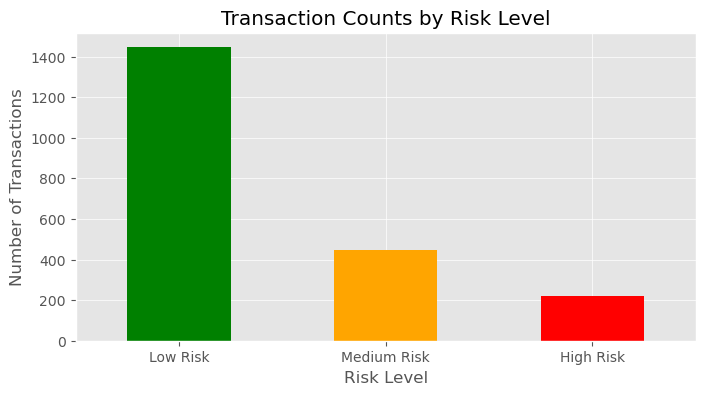

In [85]:
# Prepare risk level counts
risk_level_counts = pd.Series({
    "Low Risk": low_risk_transactions.shape[0],
    "Medium Risk": medium_risk_transactions.shape[0],
    "High Risk": high_risk_transactions.shape[0],
})


# Plotting
plt.style.use('ggplot')  # Using a nicer style
fig, ax = plt.subplots(figsize=(8, 4))
risk_level_counts.plot(kind='bar', color=['green', 'orange', 'red'], ax=ax)
ax.set_title('Transaction Counts by Risk Level')
ax.set_xlabel('Risk Level')
ax.set_ylabel('Number of Transactions')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.show()


In [86]:
total_testing_set = testing_transactions.shape[0]

This is out of the testing set of 45839. 
No Risk= 43727 --> 95.39%
Low Risk= 1445 --> 3.15%
Medium Risk= 449 --> 0.98%
High Risk= 218 --> 0.48%

In [87]:
# Resample by day and count transactions
all_anomalous_transactions['Datetime'] = pd.to_datetime(all_anomalous_transactions['Datetime'])
all_anomalous_transactions.set_index('Datetime', inplace=True)


KeyError: 'Datetime'

In [ ]:
# Resample by day and count transactions
simulated_cleaned_tx_df['Datetime'] = pd.to_datetime(simulated_cleaned_tx_df['Datetime'])
simulated_cleaned_tx_df.set_index('Datetime', inplace=True)


In [ ]:
weekly_transactions_anomalous = all_anomalous_transactions.resample('W').size()
weekly_transactions_all = simulated_cleaned_tx_df.resample('W').size()

hourly_transactions_anomalous = all_anomalous_transactions.groupby(all_anomalous_transactions.index.hour).size()
hourly_transactions_all = simulated_cleaned_tx_df.groupby(simulated_cleaned_tx_df.index.hour).size()


# Calculate the percentage of anomalous transactions each week
weekly_percentage_anomalous = (weekly_transactions_anomalous / weekly_transactions_all * 100).fillna(0)

# Calculate the percentage of anomalous transactions each hour
# This stays the same
hourly_percentage_anomalous = (hourly_transactions_anomalous / hourly_transactions_all * 100).fillna(0)

# Setup subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Plot weekly percentage of anomalous transactions
weekly_percentage_anomalous.plot(ax=ax1, title='Weekly Percentage of Anomalous Transactions', color='teal', label='Anomalous Transactions')
ax1.set_ylabel('Percentage of Anomalous Transactions')
ax1.set_xlabel('By Week in 2023')

# Plot hourly percentage of anomalous transactions
hourly_percentage_anomalous.plot(ax=ax2, kind='bar', title='Hourly Percentage of Anomalous Transactions', color='salmon', label='Anomalous Transactions')
ax2.set_ylabel('Percentage of Anomalous Transactions')
ax2.set_xlabel('Hour of Day')
ax2.set_xticks(range(0, 24))
ax2.set_xticklabels(range(0, 24), rotation=0)

# Show the plots
plt.tight_layout()
plt.show()

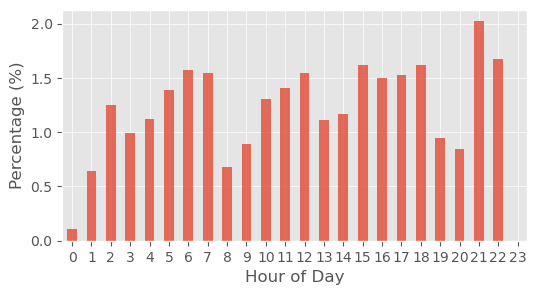

In [120]:
plt.style.use('ggplot')
# Plot hourly percentage of anomalous transactions
fig, ax = plt.subplots(figsize=(6, 3))  # Adjusted the figure size for single plot
hourly_percentage_anomalous.plot(kind='bar', label='Anomalous Transactions', alpha= 0.8, ax=ax)
#ax.set_title('Hourly Percentage of Anomalous Transactions')
ax.set_ylabel('Percentage (%)')
ax.set_xlabel('Hour of Day')
ax.set_xticks(range(0, 24))
ax.set_xticklabels(range(0, 24), rotation=0)

# Show the plot
plt.show()


In [90]:
monthly_transactions_anomalous = all_anomalous_transactions.resample('M').size()
monthly_transactions_all = simulated_cleaned_tx_df.resample('M').size()

monthly_percentage_anomalous = (monthly_transactions_anomalous / monthly_transactions_all * 100).fillna(0)

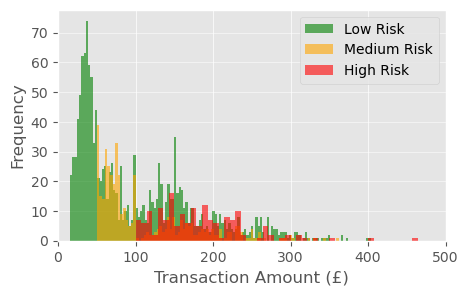

In [121]:
plt.style.use('ggplot')
plt.figure(figsize=(5, 3))  # Set the figure size

# Histogram for Low Risk Transactions
plt.hist(low_risk_expenditures['Amount'], bins=1000, color='green', alpha=0.6, label='Low Risk')

# Histogram for Medium Risk Transactions
plt.hist(medium_risk_expenditures['Amount'], bins=1000, color='orange',  alpha=0.6, label='Medium Risk')

# Histogram for High Risk Transactions
plt.hist(high_risk_expenditures['Amount'], bins=1700, color='red', alpha=0.6, label='High Risk')

# Titles and labels
#plt.title('Overlayed Distribution of Anomalous Expenditures by Risk Level and Amount')
plt.xlabel('Transaction Amount (£)')
plt.ylabel('Frequency')
plt.xlim(0, 500)  
plt.grid(axis='y', alpha=0.75)

# Legend
plt.legend(loc='upper right')

# Show the plot
plt.show()


Setting the limit in the above graph to 500

### Isolation Forest Results

In [43]:
isolation_forest_results = pd.read_csv('Isolation_forest_results.csv')

In [44]:
isolation_forest_results = isolation_forest_results.drop(columns='Prediction')
isolation_forest_results['Third Party Account No'] = np.nan

In [45]:
new_column_order = [
    'Account No', 'Hour', 'DayOfWeek', 'DayOfMonth', 'MonthOfYear',
    'Third Party Account No', 'Third Party Name', 'Amount', 'Risk Category'
]

In [46]:
isolation_forest_results = isolation_forest_results[new_column_order]
low_risk_transactions_if = isolation_forest_results[isolation_forest_results['Risk Category'] == 'Low Risk']
medium_risk_transactions_if = isolation_forest_results[isolation_forest_results['Risk Category'] == 'Medium Risk']
high_risk_transactions_if = isolation_forest_results[isolation_forest_results['Risk Category'] == 'High Risk']
all_anomalous_transactions_if = pd.concat([low_risk_transactions_if, medium_risk_transactions_if, high_risk_transactions_if])

In [47]:
all_anomalous_transactions_if

,Account No,Hour,DayOfWeek,DayOfMonth,MonthOfYear,Third Party Account No,Third Party Name,Amount,Risk Category
19,101531259.0,15,6,1,1,NaN,matalan,104.00,Low Risk
20,101531259.0,16,6,1,1,NaN,topshop,99.50,Low Risk
21,101531259.0,21,2,8,3,NaN,deliveroo,15.00,Low Risk
46,105375973.0,12,6,3,12,NaN,sportsdirect,66.17,Low Risk
190,108563213.0,19,1,31,1,NaN,tesco,64.36,Low Risk
...,...,...,...,...,...,...,...,...,...
32120,986267641.0,0,0,13,11,NaN,amazon,76.20,High Risk
32333,987656636.0,10,0,1,5,NaN,topshop,330.40,High Risk
32484,992204045.0,18,0,2,10,NaN,fittedstitch,196.66,High Risk
32526,993238248.0,20,1,11,7,NaN,tesco,284.19,High Risk


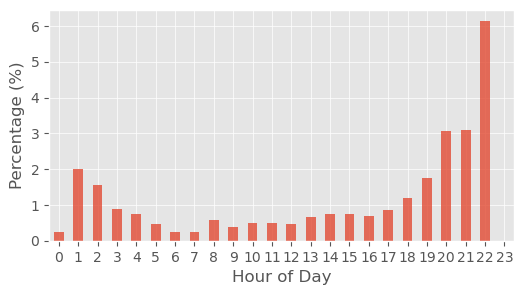

In [122]:
plt.style.use('ggplot')
hourly_transactions_anomalous_isolation_forest = all_anomalous_transactions_if.groupby('Hour').size()
hourly_percentage_anomalous_isolation_forest = (hourly_transactions_anomalous_isolation_forest / hourly_transactions_all * 100).fillna(0)

# Plot hourly percentage of anomalous transactions
fig, ax = plt.subplots(figsize=(6, 3))  # Adjusted the figure size for single plot
hourly_percentage_anomalous_isolation_forest.plot(kind='bar', alpha=0.8, label='Anomalous Transactions', ax=ax)
#ax.set_title('Hourly Percentage of Anomalous Transactions')
ax.set_ylabel('Percentage (%)')
ax.set_xlabel('Hour of Day')
ax.set_xticks(range(0, 24))
ax.set_xticklabels(range(0, 24), rotation=0)

# Show the plot
plt.show()

### Formatting the manual inference results for comparision

In [49]:
testing_transactions_expenditures = testing_transactions_expenditures.copy()


testing_transactions_expenditures['Third Party Name'] = testing_transactions_expenditures['Third Party Name'].str.lower().str.replace(' ', '')
testing_transactions_expenditures['Datetime'] = pd.to_datetime(testing_transactions_expenditures['Datetime'])
testing_transactions_expenditures['DayOfWeek'] = testing_transactions_expenditures['Datetime'].dt.dayofweek
testing_transactions_expenditures['DayOfMonth'] = testing_transactions_expenditures['Datetime'].dt.day
testing_transactions_expenditures['MonthOfYear'] = testing_transactions_expenditures['Datetime'].dt.month

testing_transactions_expenditures = testing_transactions_expenditures.copy()

testing_transactions_expenditures['Hour'] = testing_transactions_expenditures['Datetime'].dt.hour

In [50]:
columns_to_keep = ['Account No', 'Hour', 'DayOfWeek', 'DayOfMonth', 'MonthOfYear',
                   'Third Party Account No', 'Third Party Name', 'Amount', 'risk_level']

# Drop the columns not needed
testing_transactions_expenditures = testing_transactions_expenditures[columns_to_keep]

# Rename 'risk_level' to 'Risk Category' to match your target DataFrame
testing_transactions_expenditures.rename(columns={'risk_level': 'Risk Category'}, inplace=True)

In [51]:
testing_transactions_expenditures

,Account No,Hour,DayOfWeek,DayOfMonth,MonthOfYear,Third Party Account No,Third Party Name,Amount,Risk Category
50365,712474734.0,18,1,14,3,NaN,deliveroo,31.23,No Risk
50317,419550103.0,17,1,14,3,NaN,looselyfitted,125.30,No Risk
156768,834581602.0,23,3,31,8,NaN,xbox,7.00,No Risk
198076,250957494.0,9,1,31,10,NaN,sportsdirect,37.99,No Risk
46751,675231808.0,16,6,5,3,NaN,selfridges,158.90,No Risk
...,...,...,...,...,...,...,...,...,...
177952,887156614.0,23,5,30,9,NaN,mojangstudios,5.99,No Risk
138380,117308635.0,23,0,31,7,NaN,blizzard,14.99,No Risk
27201,299871610.0,14,3,2,2,NaN,topshop,55.29,No Risk
11255,656812046.0,19,2,11,1,NaN,tesco,118.16,No Risk


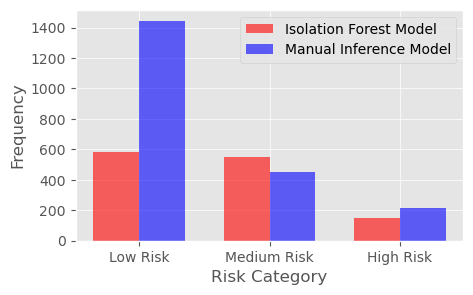

In [127]:
# Apply ggplot style

plt.style.use('ggplot')

# Assuming isolation_forest_results and testing_transactions_expenditures are predefined DataFrames
isolation_forest_model = isolation_forest_results['Risk Category'].value_counts()
manual_inference_model = testing_transactions['risk_level'].value_counts()

# Data preparation for plotting
risk_categories = ['Low Risk', 'Medium Risk', 'High Risk']
counts_isolation_forest_model = [isolation_forest_model.get(risk, 0) for risk in risk_categories]
counts_manual_inference_model = [manual_inference_model.get(risk, 0) for risk in risk_categories]

# Plotting setup
index = range(len(risk_categories))
bar_width = 0.35

# Create a figure and an axes object
fig, ax = plt.subplots(figsize=(5, 3))

# Plotting the bars with custom colors and opacity
bar1 = ax.bar(index, counts_isolation_forest_model, bar_width, label='Isolation Forest Model', color='red', alpha=0.6)
bar2 = ax.bar([p + bar_width for p in index], counts_manual_inference_model, bar_width, label='Manual Inference Model', color='blue', alpha=0.6)

# Setting the axes labels, ticks, and titles
ax.set_xlabel('Risk Category')
ax.set_ylabel('Frequency')
ax.set_xticks([p + bar_width / 2 for p in index])
ax.set_xticklabels(risk_categories)
ax.legend()

plt.show()



In [54]:
# Remove all columns that aren't featured in both dataframes
# Combine the two dataframes together, ensure both risk columns from each are fully intact
# Maybe create a third column that shows if both models featured risk
# Watch out for ID values on the columns, might need to do reset_index()

In [55]:
# Define the columns to merge on
merge_columns = ['Account No', 'Hour', 'DayOfWeek', 'DayOfMonth', 'MonthOfYear', 
                 'Third Party Account No', 'Third Party Name', 'Amount']

# Perform an inner join on the specified columns to find rows that overlap exactly on these attributes
merged_df = pd.merge(isolation_forest_results, testing_transactions_expenditures, on=merge_columns, how='inner')

# Display the first few rows of the merged DataFrame to verify the merge
merged_df

,Account No,Hour,DayOfWeek,DayOfMonth,MonthOfYear,Third Party Account No,Third Party Name,Amount,Risk Category_x,Risk Category_y
0,101531259.0,3,4,13,1,NaN,head,200.00,No Risk,No Risk
1,101531259.0,8,0,10,4,NaN,tesco,76.39,No Risk,No Risk
2,101531259.0,8,0,27,11,NaN,tesco,149.09,No Risk,No Risk
3,101531259.0,8,5,12,8,NaN,tesco,95.92,No Risk,No Risk
4,101531259.0,9,0,8,5,NaN,tesco,125.94,No Risk,No Risk
...,...,...,...,...,...,...,...,...,...,...
32626,999752672.0,18,4,22,9,NaN,tesco,71.38,No Risk,No Risk
32627,999752672.0,19,1,4,4,NaN,tesco,122.99,No Risk,No Risk
32628,999752672.0,19,2,8,3,NaN,tesco,155.53,No Risk,No Risk
32629,999752672.0,19,3,3,8,NaN,tesco,148.89,No Risk,No Risk


In [56]:
merged_df.rename(columns={
    'Risk Category_x': 'Isolation Model Risk',
    'Risk Category_y': 'Manual Inference Risk'
}, inplace=True)


In [57]:
# creating a cross tabulation with proportions
cross_tab= pd.crosstab(merged_df['Isolation Model Risk'], merged_df['Manual Inference Risk'], normalize= 'index')

# converting proportions to percentages for better readability
cross_tab_percent= cross_tab * 100
cross_tab_percent

Manual Inference Risk,High Risk,Low Risk,Medium Risk,No Risk
Isolation Model Risk,,,,
High Risk,8.800000,26.400000,10.400000,54.400000
Low Risk,0.000000,4.280822,0.513699,95.205479
Medium Risk,3.917910,16.791045,6.716418,72.574627
No Risk,0.398267,4.004970,1.201172,94.395590


In [58]:
both_flagged_as_risk = merged_df[(merged_df['Isolation Model Risk'] != 'No Risk') & (merged_df['Manual Inference Risk'] != 'No Risk')]
both_flagged_as_risk

,Account No,Hour,DayOfWeek,DayOfMonth,MonthOfYear,Third Party Account No,Third Party Name,Amount,Isolation Model Risk,Manual Inference Risk
105,108481285.0,15,4,22,9,NaN,fatface,300.30,Medium Risk,Medium Risk
119,108481285.0,17,1,7,2,NaN,topshop,249.87,Medium Risk,Medium Risk
225,108931112.0,6,5,21,1,NaN,gapkids,260.00,Low Risk,Low Risk
323,113747882.0,10,6,8,1,NaN,cex,149.97,Medium Risk,Medium Risk
344,113747882.0,18,3,27,7,NaN,fatface,401.80,High Risk,Low Risk
...,...,...,...,...,...,...,...,...,...,...
31951,986267641.0,0,0,13,11,NaN,amazon,76.20,High Risk,Medium Risk
32328,993039226.0,11,1,10,1,NaN,tesco,143.88,Medium Risk,Medium Risk
32359,993663752.0,9,1,28,2,NaN,gamestation,149.97,Medium Risk,Medium Risk
32423,994214354.0,10,5,5,8,NaN,topshop,233.79,Medium Risk,High Risk


In [59]:
both_flagged_as_same_risk = both_flagged_as_risk[(both_flagged_as_risk['Isolation Model Risk'] == both_flagged_as_risk['Manual Inference Risk'])]
both_flagged_as_same_risk

,Account No,Hour,DayOfWeek,DayOfMonth,MonthOfYear,Third Party Account No,Third Party Name,Amount,Isolation Model Risk,Manual Inference Risk
105,108481285.0,15,4,22,9,NaN,fatface,300.30,Medium Risk,Medium Risk
119,108481285.0,17,1,7,2,NaN,topshop,249.87,Medium Risk,Medium Risk
225,108931112.0,6,5,21,1,NaN,gapkids,260.00,Low Risk,Low Risk
323,113747882.0,10,6,8,1,NaN,cex,149.97,Medium Risk,Medium Risk
539,117308635.0,2,6,30,7,NaN,deliveroo,33.28,Low Risk,Low Risk
...,...,...,...,...,...,...,...,...,...,...
31816,982949451.0,19,4,17,3,NaN,tesco,162.43,Medium Risk,Medium Risk
31884,984783496.0,18,6,2,7,NaN,topshop,265.27,Medium Risk,Medium Risk
32328,993039226.0,11,1,10,1,NaN,tesco,143.88,Medium Risk,Medium Risk
32359,993663752.0,9,1,28,2,NaN,gamestation,149.97,Medium Risk,Medium Risk
